In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import binary_crossentropy
import os
import shutil
import zipfile
import random
from shutil import copyfile
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
zipFile = '/content/drive/MyDrive/dataset/merged_defect_normal.zip'

zipref = zipfile.ZipFile(zipFile,'r')
# os.makedirs('/coffee_beans')
zipref.extractall('coffee_beans/')
zipref.close()

In [3]:
source = '/content/coffee_beans/'

source_defect = os.path.join(source,'defect')
source_normal = os.path.join(source,'normal')

print(len(os.listdir(source_defect)))
print(len(os.listdir(source_normal)))

1600
4050


In [4]:
root = '/content/coffeebeans/'

if os.path.exists(root):
  shutil.rmtree(root)

In [5]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95):
      print("\nReached 5% accuracy so cancelling training!")
      self.model.stop_training = True

## **Without test directory**

In [6]:
train_dir = os.path.join(root,'train')
val_dir = os.path.join(root,'val')


train_dir_defect = os.path.join(train_dir,'defect')
train_dir_normal = os.path.join(train_dir,'normal')

val_dir_defect = os.path.join(val_dir,'defect')

val_dir_normal = os.path.join(val_dir,'normal')

In [7]:
os.makedirs(train_dir_defect)
os.makedirs(train_dir_normal)
os.makedirs(val_dir_defect)
os.makedirs(val_dir_normal)

In [8]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

    source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))
    training_len = int(len(source) * SPLIT_SIZE)

    indicator = 0
    target = TRAINING_DIR

    for item in source:
      item_source = os.path.join(SOURCE_DIR, item)
      if os.path.getsize(item_source) > 0:
        copyfile(item_source, os.path.join(target, item))
        indicator = indicator + 1
      else: 
        print('{} is zero length, so ignoring.'.format(item))
    
      if indicator == training_len:
        target = VALIDATION_DIR

In [9]:
source_dir_defect = '/content/coffee_beans/defect/'
source_dir_normal = '/content/coffee_beans/normal/'

train_dir = '/content/coffeebeans/train/'
val_dir = '/content/coffeebeans/val/'

val_dir_defect = os.path.join(val_dir,'defect/')
val_dir_normal = os.path.join(val_dir,'normal/')

train_dir_defect = os.path.join(train_dir,'defect/')
train_dir_normal = os.path.join(train_dir,'normal/')

split_size = .9

split_data(source_dir_defect,train_dir_defect,val_dir_defect,split_size)
split_data(source_dir_normal,train_dir_normal,val_dir_normal,split_size)

In [10]:
datagen_train = ImageDataGenerator(rescale=1/.255,fill_mode='nearest')

train_data = datagen_train.flow_from_directory(directory=train_dir,batch_size=50,class_mode='binary',target_size=(200,200))

datagen_val = ImageDataGenerator(rescale=1/.255,fill_mode='nearest')

val_data = datagen_val.flow_from_directory(directory=val_dir,batch_size=50,class_mode='binary',target_size=(200,200))

Found 5085 images belonging to 2 classes.
Found 565 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import backend as K

In [ ]:
def attention(x):
    # Compute attention weights
    attention_weights = K.softmax(K.squeeze(K.dot(x[0], K.expand_dims(x[1], axis=-1)), axis=-1), axis=1)

    # Apply attention weights to the input sequence
    context_vector = tf.keras.layers.Multiply()([x[0], attention_weights])
    context_vector = K.sum(context_vector, axis=1)

    return context_vector

Model Type 1 

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation=tf.nn.relu,input_shape=(200,200,3)),
    # tf.keras.layers.LSTM(64), 
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(2,2),
    # tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
    # tf.keras.layers.MaxPool2D(2,2),
    # tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
    # tf.keras.layers.MaxPool2D(2,2),
   
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Reshape((-1, 64)),
    # tf.keras.layers.Permute((2, 1)),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.GRU(64, return_sequences=True),
    # tf.keras.layers.Lambda(attention),
    # tf.keras.layers.Reshape((64,)),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
    tf.keras.layers.Dense(64,activation=tf.nn.relu),
    #  tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
])


In [17]:
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=binary_crossentropy,
    metrics=['acc']
)

In [18]:
callbacks = myCallback()
trial_model_1 = model.fit(train_data,epochs=50,verbose=1,validation_data=val_data,callbacks=callbacks)

Epoch 1/50
102/102 [==============================] - 16s 132ms/step - loss: 89.8452 - acc: 0.6704 - val_loss: 7.3872 - val_acc: 0.7168
Epoch 2/50
102/102 [==============================] - 13s 130ms/step - loss: 1.2627 - acc: 0.6901 - val_loss: 0.6335 - val_acc: 0.6938
Epoch 3/50
102/102 [==============================] - 13s 132ms/step - loss: 2.4728 - acc: 0.6979 - val_loss: 0.5691 - val_acc: 0.7186
Epoch 4/50
102/102 [==============================] - 13s 131ms/step - loss: 0.8520 - acc: 0.6991 - val_loss: 0.5898 - val_acc: 0.7204
Epoch 5/50
102/102 [==============================] - 13s 130ms/step - loss: 0.9195 - acc: 0.7042 - val_loss: 0.5428 - val_acc: 0.7345
Epoch 6/50
102/102 [==============================] - 14s 134ms/step - loss: 1.5220 - acc: 0.7302 - val_loss: 0.5478 - val_acc: 0.7257
Epoch 7/50
102/102 [==============================] - 13s 131ms/step - loss: 2.5490 - acc: 0.7306 - val_loss: 0.5641 - val_acc: 0.7416
Epoch 8/50
102/102 [==============================] - 

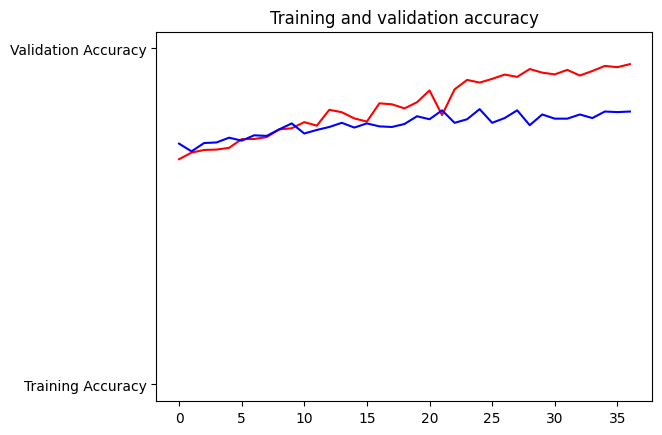

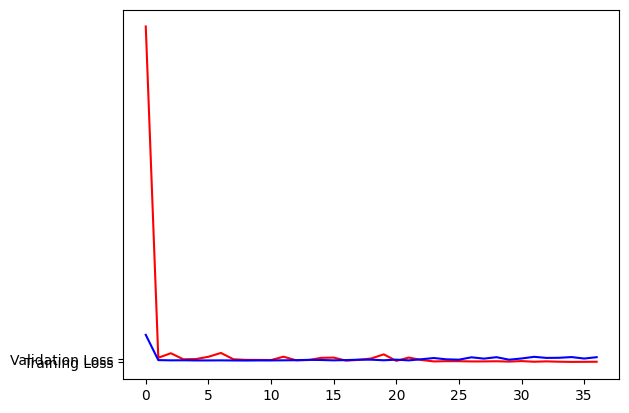

In [19]:
acc=trial_model_1.history['acc']
val_acc=trial_model_1.history['val_acc']
loss=trial_model_1.history['loss']
val_loss=trial_model_1.history['val_loss']

epochs=range(len(acc))


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 64)      

In [21]:
import pickle

filename = "trial_model_1.pkl"
pickle.dump(model,open('/content/'+filename,'wb'))

Saving Screenshot 2023-05-14 at 12.24.10.png to Screenshot 2023-05-14 at 12.24.10.png
1/1 [==============================] - 0s 154ms/step
[0.5537566]
defect


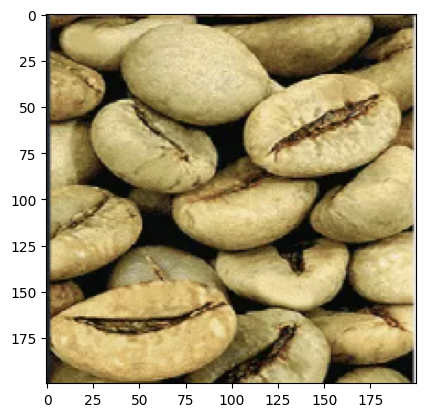

In [25]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
load_model = pickle.load(open('/content/trial_model_1.pkl','rb'))
uploaded = files.upload()

for fn in uploaded.keys():
 
#   # predicting images
  path = fn
  img = image.load_img(path, target_size=(200,200))
  imgplot = plt.imshow(img)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x]) 
  classes = load_model.predict(images) 
  print(classes[0]) 


if classes[0] > 0.9:
    print('normal')    
else:
    print('defect')

# **Using test directory**

In [6]:
train_dir = os.path.join(root,'train')
val_dir = os.path.join(root,'val')
test_dir = os.path.join(root,'test')

train_dir_defect = os.path.join(train_dir,'defect')
train_dir_normal = os.path.join(train_dir,'normal')

val_dir_defect = os.path.join(val_dir,'defect')
val_dir_normal = os.path.join(val_dir,'normal')

test_dir_defect = os.path.join(test_dir,'defect')
test_dir_normal = os.path.join(test_dir,'normal')

os.makedirs(train_dir_defect)
os.makedirs(train_dir_normal)
os.makedirs(val_dir_defect)
os.makedirs(val_dir_normal)
os.makedirs(test_dir_defect)
os.makedirs(test_dir_normal)


In [7]:

def split_data(SOURCE_DIR, TRAINING_DIR, TEST_DIR, VALIDATION_DIR, SPLIT_SIZE):

    source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))
    training_len = int(len(source) * SPLIT_SIZE)
    val_len = training_len * SPLIT_SIZE
    indicator = 0
    target = TRAINING_DIR

    for item in source:
      item_source = os.path.join(SOURCE_DIR, item)
      if os.path.getsize(item_source) > 0:
        copyfile(item_source, os.path.join(target, item))
        indicator = indicator + 1
      else: 
        print('{} is zero length, so ignoring.'.format(item))
    
      if indicator == training_len:
        target = VALIDATION_DIR
      
      if indicator == val_len:
        target = TEST_DIR

In [8]:
source_dir_defect = '/content/coffee_beans/defect/'
source_dir_normal = '/content/coffee_beans/normal/'

train_dir = '/content/coffeebeans/train/'
val_dir = '/content/coffeebeans/val/'
test_dir = '/content/coffeebeans/test/'

val_dir_defect = os.path.join(val_dir,'defect/')
val_dir_normal = os.path.join(val_dir,'normal/')

train_dir_defect = os.path.join(train_dir,'defect/')
train_dir_normal = os.path.join(train_dir,'normal/')

test_dir_defect = os.path.join(test_dir,'defect/')
test_dir_normal = os.path.join(test_dir,'normal/')

split_size = .8

split_data(source_dir_defect,train_dir_defect,val_dir_defect,test_dir_defect,split_size)
split_data(source_dir_normal,train_dir_normal,val_dir_normal,test_dir_normal,split_size)

In [9]:
datagen_train = ImageDataGenerator(rescale=1/.255,fill_mode='nearest',
                                    #  rotation_range=40,
                                    #  width_shift_range=0.2,
                                    #  height_shift_range=0.2,
                                    #  shear_range=0.2,
                                    #  zoom_range=0.2
                                    #  horizontal_flip=True
)

train_data = datagen_train.flow_from_directory(directory=train_dir,batch_size=50,class_mode='binary',target_size=(200,200))

datagen_val = ImageDataGenerator(rescale=1/.255,fill_mode='nearest',
                                    #  rotation_range=40,
                                    #  width_shift_range=0.2,
                                    #  height_shift_range=0.2,
                                    #  shear_range=0.2,
                                    #  zoom_range=0.2
                                    #  horizontal_flip=True
)
val_data = datagen_val.flow_from_directory(directory=val_dir,batch_size=50,class_mode='binary',target_size=(200,200))

Found 3616 images belonging to 2 classes.
Found 904 images belonging to 2 classes.


In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation=tf.nn.relu,input_shape=(200,200,3)),
    # tf.keras.layers.LSTM(64), 
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(2,2),
     tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(2,2),
     tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(2,2),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Reshape((-1, 64)),
    # tf.keras.layers.Permute((2, 1)),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.GRU(64, return_sequences=True),
    # tf.keras.layers.Lambda(attention),
    # tf.keras.layers.Reshape((64,)),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(128,activation=tf.nn.relu),
    tf.keras.layers.Dense(64,activation=tf.nn.relu),
    tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
])


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['acc']
)

In [ ]:
callbacks = myCallback()
trial_model_2 = model.fit(train_data,epochs=100,verbose=1,validation_data=val_data,callbacks=callbacks)

Epoch 1/100
73/73 [==============================] - 192s 3s/step - loss: 4.5211 - acc: 0.6363 - val_loss: 1.1779 - val_acc: 0.2843
Epoch 2/100
 8/73 [==>...........................] - ETA: 2:31 - loss: 0.7031 - acc: 0.6850

In [ ]:
test_generator = ImageDataGenerator(rescale=1/.255,
                                    fill_mode='nearest',
                                    #  rotation_range=40,
                                    #  width_shift_range=0.2,
                                    #  height_shift_range=0.2,
                                    #  shear_range=0.2,
                                    #  zoom_range=0.2
                                    #  horizontal_flip=True
                                    )
test_data = test_generator.flow_from_directory(directory=test_dir,batch_size=50,class_mode='binary',target_size=(200,200))

In [ ]:
test_model = model.evaluate(test_data)
# test_model = model.evaluate(test_dir)

In [ ]:
acc=trial_model_2.history['acc']
val_acc=trial_model_2.history['val_acc']
loss=trial_model_2.history['loss']
val_loss=trial_model_2.history['val_loss']
# test_loss = int(test_model['loss'])
# test_acc = int(test_model['acc'])
# test_range = int(len(test_dir))
epochs=range(len(acc))

# test_result = len(test_model)

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


# plt.plot(test_range, test_acc, 'b', "Test Accuracy")
# plt.plot(test_range, test_loss, 'r', "Test Loss")

plt.show()
# plt.plot(tmodelest_,'r','test accuracy')
# plt.show()

In [27]:
import pickle

filename = "trial_model_3.pkl"
pickle.dump(model,open("/content/"+filename,'wb'))

Saving Screenshot 2023-05-14 at 19.31.11.png to Screenshot 2023-05-14 at 19.31.11.png
1/1 [==============================] - 0s 105ms/step
[0.38772827]
defect


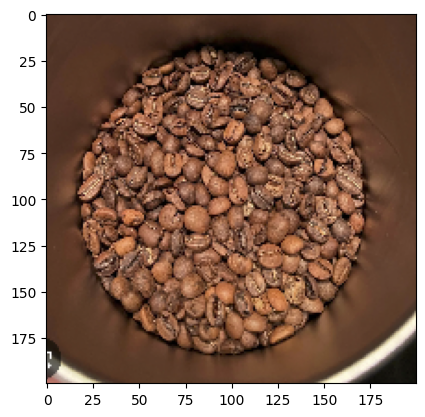

In [24]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()
loaded_model = pickle.load(open('/content/trial_model_2.pkl','rb'))
for fn in uploaded.keys():
 
#   # predicting images
  path = fn
  img = image.load_img(path, target_size=(200,200))
  imgplot = plt.imshow(img)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x]) 
  classes = loaded_model.predict(images) 
  print(classes[0]) 


if classes[0] > 0.9:
    print('normal')    
else:
    print('defect')

# **InceptionV3**

In [ ]:
train_dir = os.path.join(root,'train')
val_dir = os.path.join(root,'val')


train_dir_defect = os.path.join(train_dir,'defect')
train_dir_normal = os.path.join(train_dir,'normal')

val_dir_defect = os.path.join(val_dir,'defect')

val_dir_normal = os.path.join(val_dir,'normal')

os.makedirs(train_dir_defect)
os.makedirs(train_dir_normal)
os.makedirs(val_dir_defect)
os.makedirs(val_dir_normal)

In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

    source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))
    training_len = int(len(source) * SPLIT_SIZE)

    indicator = 0
    target = TRAINING_DIR

    for item in source:
      item_source = os.path.join(SOURCE_DIR, item)
      if os.path.getsize(item_source) > 0:
        copyfile(item_source, os.path.join(target, item))
        indicator = indicator + 1
      else: 
        print('{} is zero length, so ignoring.'.format(item))
    
      if indicator == training_len:
        target = VALIDATION_DIR

In [ ]:
source_dir_defect = 'coffee_beans/defect/'
source_dir_normal = 'coffee_beans/normal/'

train_dir = 'coffeebeans/train/'
val_dir = 'coffeebeans/val/'

val_dir_defect = os.path.join(val_dir,'defect/')
val_dir_normal = os.path.join(val_dir,'normal/')

train_dir_defect = os.path.join(train_dir,'defect/')
train_dir_normal = os.path.join(train_dir,'normal/')

split_size = .9

split_data(source_dir_defect,train_dir_defect,val_dir_defect,split_size)
split_data(source_dir_normal,train_dir_normal,val_dir_normal,split_size)

In [ ]:
datagen_train = ImageDataGenerator(rescale=1/.255,fill_mode='nearest')

train_data = datagen_train.flow_from_directory(directory=train_dir,batch_size=50,class_mode='binary',target_size=(200,200))

datagen_val = ImageDataGenerator(rescale=1/.255,fill_mode='nearest')

val_data = datagen_val.flow_from_directory(directory=val_dir,batch_size=50,class_mode='binary',target_size=(200,200))

Found 5085 images belonging to 2 classes.
Found 565 images belonging to 2 classes.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

zsh:1: command not found: wget


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from keras.applications import inception_v3

local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (200,200,3),
                                  include_top = False, 
                                  weights ='imagenet') 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
      layer.trainable = False

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 99, 99, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 99, 99, 32)           96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 99, 99, 32)           0         ['batch_normalizati

In [ ]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)


  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 10, 10, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 10, 10, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [ ]:
def create_final_model(pre_trained_model, last_output):

  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = tf.keras.layers.Dense(1024,activation='relu')(x)
  # x = tf.keras.layers.Dense(128,activation='relu')(x)
  # Add a dropout rate of 0.2
  x = tf.keras.layers.Dropout(0.2)(x) 
  # Add a final sigmoid layer for classification
  x = tf.keras.layers.Dense(1,activation='sigmoid')(x)  

  # Create the complete model by using the Model class
  model = tf.keras.Model(inputs=pre_trained_model.input,outputs=x)

  
  # Compile the model
  model.compile(optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001), 
                loss = tf.keras.losses.binary_crossentropy,
                metrics = ['acc'])

 
  
  return model

In [ ]:
callbacks = myCallback()
model = create_final_model(pre_trained_model, last_output)

In [ ]:

trial_model_3 = model.fit(train_data,validation_data=val_data,epochs=30,verbose=2,callbacks=callbacks)

Epoch 1/30


2023-05-21 08:32:08.783416: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
acc=trial_model_2.history['acc']
val_acc=trial_model_2.history['val_acc']
loss=trial_model_2.history['loss']
val_loss=trial_model_2.history['val_loss']
# test_loss = int(test_model['loss'])
# test_acc = int(test_model['acc'])
# test_range = int(len(test_dir))
epochs=range(len(acc))

# test_result = len(test_model)

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


# plt.plot(test_range, test_acc, 'b', "Test Accuracy")
# plt.plot(test_range, test_loss, 'r', "Test Loss")

plt.show()
# plt.plot(tmodelest_,'r','test accuracy')
# plt.show()

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
#   # predicting images
  path = fn
  img = image.load_img(path, target_size=(200,200))
  imgplot = plt.imshow(img)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x]) 
  classes = model.predict(images) 
  print(classes[0]) 


if classes[0] > 0.9:
    print('normal')    
else:
    print('defect')